In [ ]:
!pip install pystan
!pip install nest_asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 550.3 kB/s eta 0:00:00


In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

from scipy.spatial.distance import cdist
import nest_asyncio
nest_asyncio.apply()

import stan
from IPython.display import HTML

In [ ]:
def rbf(x, y, center_x, center_y, width):
    """Evaluate a radial basis function at a given point."""
    return np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * width**2))

def create_rbf_map(center_x, center_y, width, x_bounds, y_bounds, x_res, y_res):
    """Create a map of RBF values."""
    # Generate grid of coordinates
    x_coords = np.linspace(x_bounds[0], x_bounds[1], x_res)
    y_coords = np.linspace(y_bounds[0], y_bounds[1], y_res)

    # Initialize matrix to store RBF values
    rbf_matrix = np.zeros((y_res, x_res))

    # Evaluate RBF at each point in the grid
    for i, y in enumerate(y_coords):
        for j, x in enumerate(x_coords):
            rbf_matrix[i, j] = rbf(x, y, center_x, center_y, width)

    return rbf_matrix

In [ ]:
def create_combined_rbf_map(centers, widths, weights, x_bounds, y_bounds, x_res, y_res):
    combined_map = np.zeros((y_res, x_res))

    for center, width, weight in zip(centers, widths, weights):
        center_x, center_y = center
        rbf_map = create_rbf_map(center_x, center_y, width, x_bounds, y_bounds, x_res, y_res)
        combined_map += weight * rbf_map

    return combined_map

In [ ]:
def generate_rbf_parameters(k, x_bounds, y_bounds, gamma_shape, gamma_scale, beta_alpha, beta_beta):
    centers = []
    widths = []
    weights = []

    for _ in range(k):
        # Randomly select center within bounds
        center_x = np.random.uniform(x_bounds[0], x_bounds[1])
        center_y = np.random.uniform(y_bounds[0], y_bounds[1])
        centers.append((center_x, center_y))

        # Draw width from gamma distribution
        width = np.random.gamma(gamma_shape, gamma_scale)
        widths.append(width)

        # Draw weight from beta distribution
        weight = np.random.beta(beta_alpha, beta_beta)
        weights.append(weight)

    return centers, widths, weights

# Example usage
k = 5
x_bounds = [-5, 5]
y_bounds = [-5, 5]
x_res = 50
y_res = 50
gamma_shape = 2
gamma_scale = 1
beta_alpha = 2
beta_beta = 3

centers, widths, weights = generate_rbf_parameters(k, x_bounds, y_bounds, gamma_shape, gamma_scale, beta_alpha, beta_beta)

<Axes: >

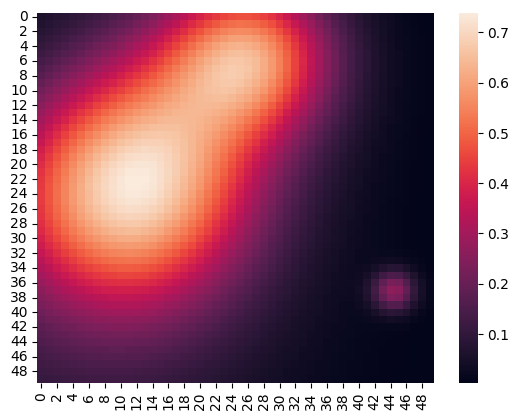

In [ ]:
combined_map = create_combined_rbf_map(centers, widths, weights, x_bounds, y_bounds, x_res, y_res)
sns.heatmap(combined_map)

In [ ]:
def extract_rbf_parameters_from_results(fit, M):
    # Convert the Stan fit object to a pandas DataFrame
    df = fit.to_frame()

    # Extract the last set of parameters from the DataFrame
    last_result = df.iloc[-1]

    centers = [(last_result[f'centers.{i+1}.1'], last_result[f'centers.{i+1}.2']) for i in range(M)]
    widths = [last_result[f'widths.{i+1}'] for i in range(M)]
    weights = [last_result[f'weights.{i+1}'] for i in range(M)]

    return centers, widths, weights

In [ ]:
def create_rbf_animation(centers, widths, weights, animate, x_bounds, y_bounds, x_res, y_res):
    def create_single_combined_map(centers, widths, weights):
        combined_map = np.zeros((y_res, x_res))
        for center, width, weight in zip(centers, widths, weights):
            rbf_map = create_rbf_map(center[0], center[1], width, x_bounds, y_bounds, x_res, y_res)
            combined_map += weight * rbf_map
        return combined_map

    n_iterations = centers.shape[2]
    if animate:
        fig, ax = plt.subplots()
        def animate_func(i):
            ax.clear()
            combined_map = create_single_combined_map(centers[:, :, i], widths[:, i], weights[:, i])
            ax.imshow(combined_map, extent=x_bounds + y_bounds, origin='lower')
            ax.set_title(f"Iteration {i+1}")
            return ax,

        anim = FuncAnimation(fig, animate_func, frames=n_iterations, interval=100)
        return anim
    else:
        combined_map = create_single_combined_map(centers[:, :, -1], widths[:, -1], weights[:, -1])
        plt.imshow(combined_map, extent=x_bounds + y_bounds, origin='lower')
        plt.title("Final Iteration")
        plt.show()


In [ ]:
def select_furthest_coordinate(pairwise_distances, sampled_indices):
    # If all points have been sampled, return None
    if len(sampled_indices) == len(pairwise_distances):
        return None

    # Exclude sampled points by setting their distances to infinity
    modified_distances = np.copy(pairwise_distances)
    modified_distances[:, sampled_indices] = np.inf

    # Find the minimum distance to a sampled point for each unsampled point
    min_distances = np.min(modified_distances, axis=1)

    # Find the index of the point that has the maximum of these minimum distances
    furthest_point_index = np.argmax(min_distances)

    # Check if all points are sampled (min_distances are all infinity)
    if np.isinf(min_distances[furthest_point_index]):
        return None

    return furthest_point_index, min_distances[furthest_point_index]

# Example usage:
# Assuming pairwise_distances is precomputed and sampled_indices is maintained
# furthest_point_index, distance = select_furthest_coordinate(pairwise_distances, sampled_indices)


In [ ]:
def initialize_coordinates_and_distances(x_bounds, y_bounds, x_res, y_res):
    # Generate all coordinates
    x = np.linspace(x_bounds[0], x_bounds[1], x_res)
    y = np.linspace(y_bounds[0], y_bounds[1], y_res)
    X, Y = np.meshgrid(x, y)
    all_coordinates = np.column_stack([X.ravel(), Y.ravel()])

    # Initialize sampled_indices as an empty list
    sampled_indices = []

    # Precompute the pairwise distances between all coordinates
    pairwise_distances = cdist(all_coordinates, all_coordinates)

    return all_coordinates, sampled_indices, pairwise_distances

all_coordinates, sampled_indices, pairwise_distances = initialize_coordinates_and_distances(x_bounds, y_bounds, x_res, y_res)

In [ ]:
M = 4

stan_model = """
data {
    int<lower=0> N;  // Number of observations
    vector[N] activations;  // Activation values
    array[N, 2] real coordinates;  // Coordinates (x, y) for each observation
    int<lower=1> M;  // Number of RBFs to infer
}

parameters {
    array[M, 2] real centers;  // Centers of RBFs
    array[M] real<lower=0> widths;  // Widths of RBFs
    array[M] real<lower=0, upper=1> weights;  // Weights of RBFs
    real<lower=0> sigma;  // Noise level
}

model {
    // Priors for RBF parameters
    for (m in 1:M) {
        centers[m] ~ normal(0, 10);  // Example: Center prior
        widths[m] ~ gamma(2, 1);  // Example: Width prior
        weights[m] ~ beta(2, 2);  // Example: Weight prior
    }
    sigma ~ normal(0, 1);  // Example: Noise level prior

    // Likelihood of observations
    for (n in 1:N) {
        real predicted_activation = 0;
        for (m in 1:M) {
            real dist = sqrt(square(coordinates[n][1] - centers[m][1]) + square(coordinates[n][2] - centers[m][2]));
            predicted_activation += weights[m] * exp(-0.5 * square(dist / widths[m]));
        }
        activations[n] ~ normal(predicted_activation, sigma);
    }
}
"""

In [ ]:
def run_stan_inference(stan_model, observations, M):
    # Prepare data for Stan
    stan_data = {
        'N': len(observations),
        'activations': np.array([obs[1] for obs in observations]),
        'coordinates': np.array([obs[0] for obs in observations]),
        'M': M  # Number of RBFs to infer
    }

    # Rebuild the model with the new data
    compiled_model = stan.build(stan_model, data=stan_data)

    # Sample from the compiled model
    fit = compiled_model.sample(num_chains=4, num_samples=1000)

    # Extract parameters from the fit object
    extracted_parameters = extract_rbf_parameters_from_results(fit, M)

    return extracted_parameters

In [ ]:
def active_sampling_inference(model, combined_map, M, n_iter, x_bounds, y_bounds, x_res, y_res):
    # Initialize all coordinates and pairwise distances
    all_coordinates, sampled_indices, pairwise_distances = initialize_coordinates_and_distances(x_bounds, y_bounds, x_res, y_res)

    # Initialize observations list
    observations = []

    # Function to convert coordinates to map indices
    def coords_to_indices(coord, x_bounds, y_bounds, x_res, y_res):
        x_idx = int((coord[0] - x_bounds[0]) / (x_bounds[1] - x_bounds[0]) * (x_res - 1))
        y_idx = int((coord[1] - y_bounds[0]) / (y_bounds[1] - y_bounds[0]) * (y_res - 1))
        return x_idx, y_idx

    inferred_rbf_results = []

    # Outer loop for active sampling
    for _ in range(n_iter):
        furthest_point_index, _ = select_furthest_coordinate(pairwise_distances, sampled_indices)
        if furthest_point_index is None:
            break  # Break if all points have been sampled

        sampled_indices.append(furthest_point_index)
        coordinate = all_coordinates[furthest_point_index]

        # Convert coordinate to map indices
        x_idx, y_idx = coords_to_indices(coordinate, x_bounds, y_bounds, x_res, y_res)
        activation = combined_map[x_idx, y_idx]
        observations.append((coordinate, activation))

        # Run inference and store results
        iteration_results = run_stan_inference(model, observations, M)
        inferred_rbf_results.append(iteration_results)

    #final_rbf_parameters = results.tail(1)
    return inferred_rbf_results, observations


In [ ]:
inferred_rbf_results, observations = active_sampling_inference(stan_model, combined_map, 4, 3, x_bounds, y_bounds, x_res, y_res)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   5% (401/8000)
Sampling:   9% (700/8000)
Sampling:  14% (1100/8000)
Sampling:  35% (2800/8000)
Sampling:  60% (4800/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations acc

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   3% (201/8000)
Sampling:   4% (300/8000)
Sampling:   9% (700/8000)
Sampling:  12% (1000/8000)
Sampling:  16% (1300/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  38% (3001/8000)
Sampling:  51% (4101/8000)
Sampling:  53% (4201/8000)
Sampling:  54% (4300/8000)
Sampling:  55% (4400/8000)
Sampling:  56% (4500/8000)
Sampling:  58% (4600/8000)
Sampling:  59% (4700/8000)
Sampling:  60% (4800/8000)
Sampling:  61% (4900/8000)
Sampling:  62% (5000/8000)
Sampling:  64% (5100/8000)
Sampling:  65% (5200/8000)
Sampling:  66% (5300/8000)
Sampling:  68% (5400/8000)
Sampling:  69% (5500/8000)
Sampling:  82% (6600/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1901/8000)
Sampling:  38% (3001/8000)
Sampling:  39% (3100/8000)
Sampling:  39% (3101/8000)
Sampling:  40% (3201/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
Sampling:  44% (3500/8000)
Sampling:  45% (3600/8000)
Sampling:  46% (3700/8000)
Sampling:  48% (3800/8000)
Sampling:  49% (3900/8000)
Sampling:  50% (4000/8000)
Sampling:  51% (4100/8000)
Sampling:  52% (4200/8000)
Sampling:  54% (4300/80

In [ ]:
def animate(frame, axs, true_rbf_params, inferred_rbf_results, observations, all_coordinates, x_bounds, y_bounds, x_res, y_res):
    # Clear the axes for the new frame
    for ax in axs:
        ax.clear()

    # Create the true combined map from true RBF parameters
    true_map = create_combined_rbf_map(*true_rbf_params, x_bounds, y_bounds, x_res, y_res)

    # Extract estimated RBF parameters for the current frame
    est_centers, est_widths, est_weights = inferred_rbf_results[frame]

    # Create the estimated combined map from estimated RBF parameters
    estimated_map = create_combined_rbf_map(est_centers, est_widths, est_weights, x_bounds, y_bounds, x_res, y_res)

    # Setup the subplot structure
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Left panel: True heatmap with true RBF parameters
    axs[0].imshow(true_map, extent=[x_bounds[0], x_bounds[1], y_bounds[0], y_bounds[1]], origin='lower')
    axs[0].set_xlim(x_bounds)
    axs[0].set_ylim(y_bounds)
    for center, width in zip(*true_rbf_params[:2]):
        axs[0].scatter(*center, color='black', marker='x')
        circle = Circle(center, width, fill=False, edgecolor='black', linestyle='--')
        axs[0].add_patch(circle)
    axs[0].set_title("True Heatmap")

    # Right panel: Estimated heatmap
    axs[1].imshow(estimated_map, extent=[x_bounds[0], x_bounds[1], y_bounds[0], y_bounds[1]], origin='lower')
    axs[1].set_xlim(x_bounds)
    axs[1].set_ylim(y_bounds)
    for center, width in zip(est_centers, est_widths):
        axs[1].scatter(*center, color='black', marker='x')
        circle = Circle(center, width, fill=False, edgecolor='black', linestyle='--')
        axs[1].add_patch(circle)
    # Overlay observations
    for obs in observations[:frame+1]:
        axs[1].scatter(*obs[0], color='red', marker='o')
    axs[1].set_title("Estimated Heatmap")

    return fig, axs

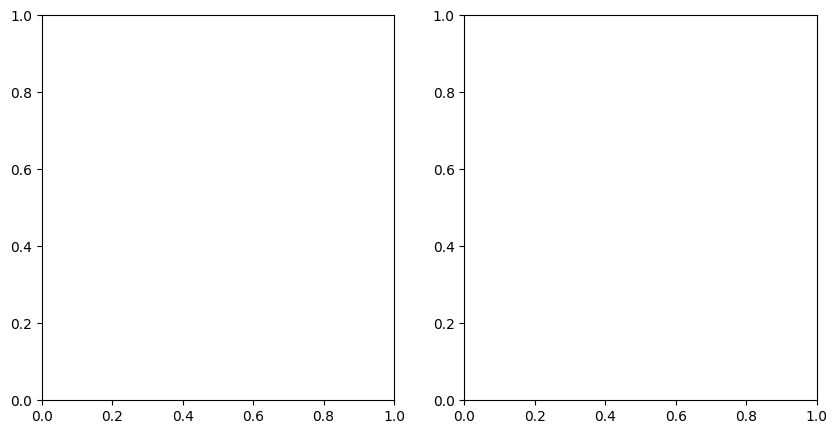

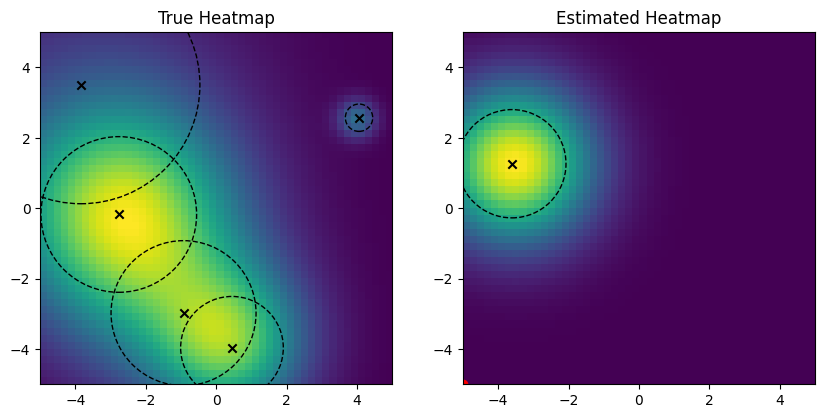

In [ ]:
# Create and use the animation
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
true_rbf_params = [centers, widths, weights]
all_coordinates, _, _ = initialize_coordinates_and_distances(x_bounds, y_bounds, x_res, y_res)

anim = FuncAnimation(fig, animate, frames=len(inferred_rbf_results),
                     fargs=(axs, true_rbf_params, inferred_rbf_results, observations, all_coordinates, x_bounds, y_bounds, x_res, y_res),
                     interval=200);

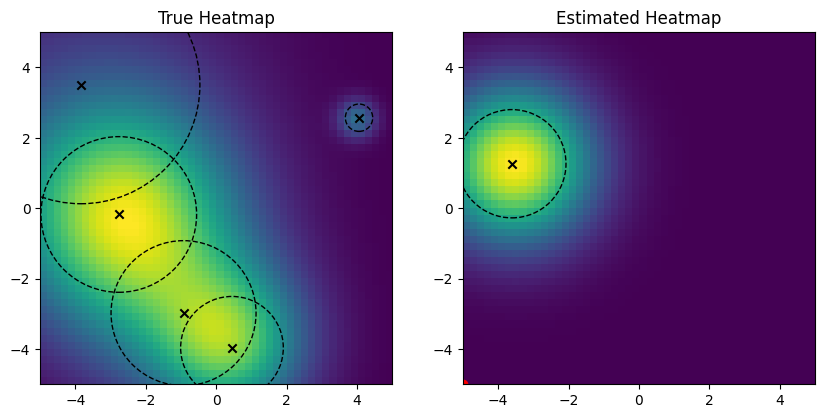

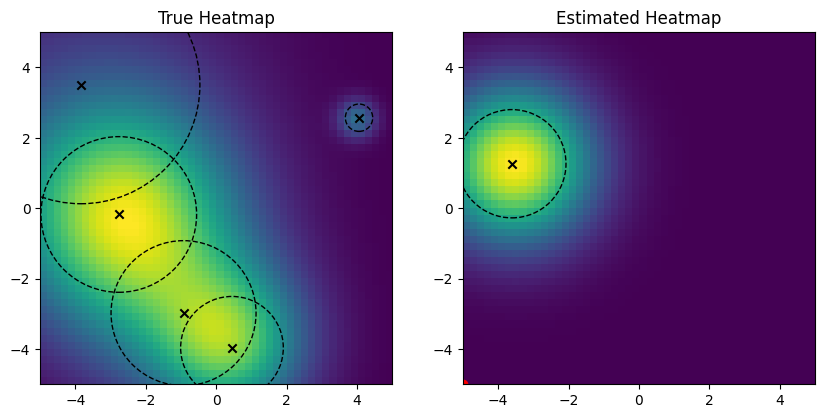

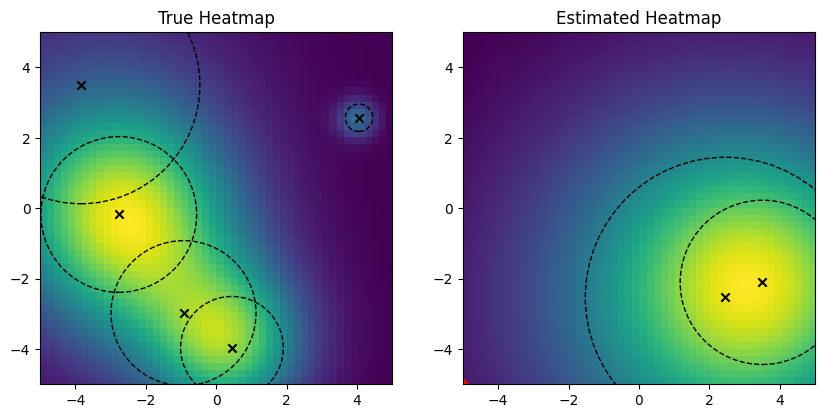

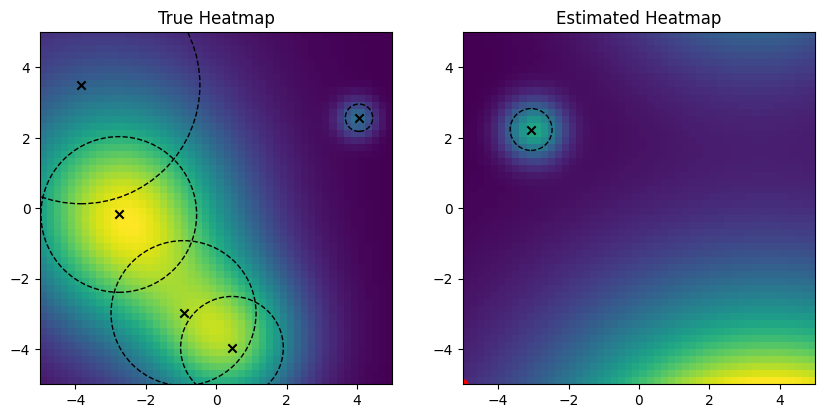

In [ ]:
HTML(anim.to_html5_video())